In [1]:
### CELL-2 ###
# Load the raw CIFAR-10 data
from data_utils import load_CIFAR10

cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [2]:
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils, layers, activations, models, losses, optimizers, metrics, callbacks, datasets, preprocessing

In [4]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [5]:
train_data, train_label, test_data, test_label = load_CIFAR10(cifar10_dir)

In [6]:
# Normalizing
train_data_proc = train_data / 255
test_data_proc = test_data / 255

#One hot encoding
train_label_proc = utils.to_categorical(train_label, 10)
test_label_proc = utils.to_categorical(test_label, 10)

In [7]:
image_gen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.05,
    zoom_range=0.3
)
train_gen = image_gen.flow(train_data_proc, train_label_proc, batch_size=32)

In [8]:
mInput = layers.Input((32, 32, 3))

In [9]:
mB1 = layers.Conv2D(64, 3, padding="same", activation="relu", name="B1_Conv_1")(mInput)
mB1 = layers.BatchNormalization(name="B1_Norm_1")(mB1)
mB1 = layers.Conv2D(64, 3, padding="same", activation="relu", name="B1_Conv_2")(mB1)
mB1 = layers.BatchNormalization(name="B1_Norm_2")(mB1)
mB1 = layers.MaxPool2D(2, strides=1, name="B1_Pool")(mB1)
mB1 = layers.Dropout(0.2, name="B1_Drop")(mB1)

In [10]:
mB2 = layers.Conv2D(64, 3, padding="same", activation="relu", name="B2_Conv_1")(mB1)
mB2 = layers.BatchNormalization(name="B2_Norm_1")(mB2)
mB2 = layers.Conv2D(128, 3, dilation_rate=2, activation="relu", name="B2_Conv_2")(mB2)
mB2 = layers.BatchNormalization(name="B2_Norm_2")(mB2)
mB2 = layers.MaxPool2D(2, strides=1, name="B2_Pool")(mB2)
mB2 = layers.Dropout(0.25, name="B2_Drop")(mB2)

In [11]:
mB3     = layers.Conv2D(128, 3, padding="same", activation="relu", name="B3_Conv_1")(mB1)
mB3     = layers.BatchNormalization(name="B3_Norm_1")(mB3)
mB3     = layers.Conv2D(256, 3, padding="same", dilation_rate=2, activation="relu", name="B3_Conv_2")(mB3)
mB3     = layers.BatchNormalization(name="B3_Norm_2")(mB3)
mB3Pool = layers.MaxPool2D(2, strides=1, name="B3_Pool")(mB3)
mB3     = layers.Dropout(0.3, name="B3_Drop")(mB3Pool)

mB4     = layers.Conv2D(128, 3, padding="same", activation="relu", name="B4_Conv_1")(mB3)
mB4     = layers.BatchNormalization(name="B4_Norm_1")(mB4)
mB4     = layers.Conv2D(256, 3, padding="same", activation="relu", name="B4_Conv_2")(mB4)
mB4     = layers.add([mB4, mB3Pool], name="B4_Add")
mB4Nor  = layers.BatchNormalization(name="B4_Norm_2")(mB4)
mB4Dout = layers.Dropout(0.35, name="B4_Drop")(mB4Nor)

mB5 = layers.Conv2D(128, 3, dilation_rate=2, padding="same", activation="relu", name="B5_Conv_1")(mB4Nor)
mB5 = layers.BatchNormalization(name="B5_Norm")(mB5)
mB5 = layers.Conv2D(256, 3, dilation_rate=3, padding="same", activation="relu", name="B5_Conv_2")(mB5)

mB6 = layers.Conv2D(128, 5, padding="same", activation="relu", name="B6_Conv_1")(mB4Nor)
mB6 = layers.BatchNormalization(name="B6_Norm")(mB6)
mB6 = layers.Conv2D(256, 5, padding="same", activation="relu", name="B6_Conv_2")(mB6)

mB7 = layers.Conv2D(128, 3, padding="same", activation="relu", name="B7_Conv_1")(mB4Dout)
mB7 = layers.BatchNormalization(name="B7_Norm_1")(mB7)
mB7 = layers.Conv2D(256, 3, padding="same", activation="relu", name="B7_Conv_2")(mB7)
mB7 = layers.add([mB5, mB6, mB7], name="B7_Add")
mB7 = layers.BatchNormalization(name="B7_Norm_2")(mB7)
mB7 = layers.Dropout(0.4, name="B7_Drop")(mB7)

mB8 = layers.Conv2D(128, 3, padding="same", activation="relu", name="B8_Conv_1")(mB7)
mB8 = layers.BatchNormalization(name="B8_Norm_1")(mB8)
mB8 = layers.Conv2D(256, 3, padding="same", dilation_rate=2, activation="relu", name="B8_Conv_2")(mB8)
mB8 = layers.add([mB3Pool, mB5, mB7, mB8], name="B8_Add")
mB8 = layers.BatchNormalization(name="B8_Norm_2")(mB8)
mB8 = layers.Dropout(0.45, name="B8_Drop")(mB8)

mB9 = layers.Conv2D(256, 3, activation="relu", name="B9_Conv_1")(mB8)
mB9 = layers.BatchNormalization(name="B9_Norm_1")(mB9)
mB9 = layers.Conv2D(256, 3, dilation_rate=2, activation="relu", name="B9_Conv_2")(mB9)
mB9 = layers.BatchNormalization(name="B9_Norm_2")(mB9)
mB9 = layers.MaxPool2D(2, name="B9_Pool")(mB9)
mB9 = layers.Dropout(0.5, name="B9_Drop")(mB9)

mB10 = layers.Conv2D(512, 3, padding="same", activation="relu", name="B8_Conv")(mB9)
mB10 = layers.GlobalAveragePooling2D(name="B10_Pool")(mB10)
mB10 = layers.BatchNormalization(name="B10_Norm")(mB10)

mOutput = layers.Dense(10, activation="softmax", name="Output")(mB10)

model = models.Model(mInput, mOutput)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
B1_Conv_1 (Conv2D)              (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
B1_Norm_1 (BatchNormalization)  (None, 32, 32, 64)   256         B1_Conv_1[0][0]                  
__________________________________________________________________________________________________
B1_Conv_2 (Conv2D)              (None, 32, 32, 64)   36928       B1_Norm_1[0][0]                  
______________________________________________________________________________________________

In [12]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=["accuracy"],
)

In [13]:
history_aug = model.fit(
    train_gen,
    epochs=100,
    validation_data=(test_data_proc, test_label_proc),
 )

  ...
    to  
  ['...']
Train for 1563 steps, validate on 10000 samples
Epoch 1/100
1563/1563 [==============================] - 217s 139ms/step - loss: 1.7427 - accuracy: 0.3662 - val_loss: 4.3009 - val_accuracy: 0.2130
Epoch 2/100
1563/1563 [==============================] - 212s 136ms/step - loss: 1.3828 - accuracy: 0.5080 - val_loss: 1.4060 - val_accuracy: 0.5591
Epoch 3/100
1563/1563 [==============================] - 212s 136ms/step - loss: 1.1550 - accuracy: 0.5960 - val_loss: 1.3782 - val_accuracy: 0.5785
Epoch 4/100
1563/1563 [==============================] - 212s 136ms/step - loss: 0.9928 - accuracy: 0.6545 - val_loss: 0.8812 - val_accuracy: 0.7053
Epoch 5/100
1563/1563 [==============================] - 211s 135ms/step - loss: 0.8800 - accuracy: 0.6970 - val_loss: 1.0368 - val_accuracy: 0.6768
Epoch 6/100
1563/1563 [==============================] - 211s 135ms/step - loss: 0.7945 - accuracy: 0.7282 - val_loss: 0.6908 - val_accuracy: 0.7772
Epoch 7/100
1563/1563 [==========

Epoch 55/100
1563/1563 [==============================] - 209s 134ms/step - loss: 0.1758 - accuracy: 0.9394 - val_loss: 0.3411 - val_accuracy: 0.9113
Epoch 56/100
1563/1563 [==============================] - 210s 134ms/step - loss: 0.1784 - accuracy: 0.9381 - val_loss: 0.3958 - val_accuracy: 0.8995
Epoch 57/100
1563/1563 [==============================] - 210s 134ms/step - loss: 0.1719 - accuracy: 0.9408 - val_loss: 0.3828 - val_accuracy: 0.9049
Epoch 58/100
1563/1563 [==============================] - 209s 134ms/step - loss: 0.1708 - accuracy: 0.9409 - val_loss: 0.3530 - val_accuracy: 0.9093
Epoch 59/100
1563/1563 [==============================] - 209s 134ms/step - loss: 0.1641 - accuracy: 0.9437 - val_loss: 0.3317 - val_accuracy: 0.9133
Epoch 60/100
1563/1563 [==============================] - 210s 134ms/step - loss: 0.1661 - accuracy: 0.9438 - val_loss: 0.3376 - val_accuracy: 0.9151
Epoch 61/100
1563/1563 [==============================] - 209s 134ms/step - loss: 0.1611 - accuracy:

<AxesSubplot:>

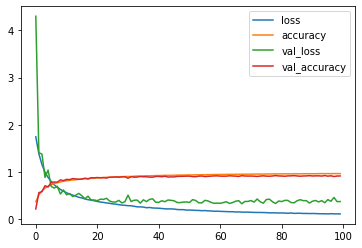

In [14]:
pd.DataFrame(history_aug.history).plot()

In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

@interact(idx=(0, 9999, 1))
def showTestImage(idx):
    data = test_data[idx].reshape(-1, 32, 32, 3)/255.0
    dataPred = model.predict(data)
    
    plt.imshow(test_data[idx].astype('uint16'))
    plt.grid(False)
    plt.title(f"LABEL: {class_names[test_label[idx]]}, PREDICT: {class_names[np.argmax(dataPred)]}")
    plt.show()

interactive(children=(IntSlider(value=4999, description='idx', max=9999), Output()), _dom_classes=('widget-int…

In [16]:
err_idx = []
pred_result = model.predict(test_data_proc)

for idx in range(10000):
    if np.argmax(pred_result[idx]) != test_label[idx]:
        err_idx.append(idx)

In [17]:
len(err_idx), err_idx

(875,
 [3,
  33,
  37,
  47,
  58,
  59,
  74,
  86,
  87,
  118,
  127,
  128,
  147,
  158,
  164,
  165,
  178,
  192,
  195,
  210,
  213,
  226,
  228,
  237,
  255,
  264,
  273,
  287,
  293,
  313,
  315,
  324,
  352,
  355,
  356,
  378,
  384,
  394,
  396,
  405,
  422,
  426,
  433,
  449,
  456,
  480,
  483,
  485,
  488,
  526,
  537,
  598,
  640,
  665,
  672,
  683,
  689,
  725,
  727,
  731,
  734,
  768,
  770,
  776,
  779,
  798,
  810,
  811,
  831,
  835,
  866,
  885,
  888,
  916,
  924,
  925,
  929,
  943,
  956,
  966,
  972,
  982,
  989,
  991,
  1001,
  1019,
  1026,
  1042,
  1050,
  1051,
  1074,
  1090,
  1093,
  1095,
  1109,
  1120,
  1131,
  1150,
  1163,
  1177,
  1181,
  1201,
  1203,
  1217,
  1222,
  1224,
  1227,
  1247,
  1263,
  1277,
  1280,
  1299,
  1321,
  1322,
  1323,
  1325,
  1339,
  1353,
  1355,
  1393,
  1398,
  1429,
  1439,
  1446,
  1453,
  1461,
  1470,
  1474,
  1479,
  1492,
  1495,
  1496,
  1506,
  1507,
  1529,
  1530,
